# Application to Disease Dynamics

In [ ]:
# !pip install deepxde  # Run this line if you are in Google Colab

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import deepxde as dde

from deepxde.backend import tf
from scipy.integrate import solve_ivp

sns.set_theme(style="darkgrid")

Using backend: tensorflow.compat.v1

2023-03-15 16:43:43.979996: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-15 16:43:44.076779: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-15 16:43:44.530668: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/alonsolml/mambaforge/envs/nc-bo

Instructions for updating:
non-resource variables are not supported in the long term
Enable just-in-time compilation with XLA.



2023-03-15 16:43:44.962419: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-15 16:43:44.982489: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-15 16:43:44.982547: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


SIRD compartmental models are mathematical models used to describe the spread of infectious diseases in a population. The name _SIRD_ stands for _Susceptible_, _Infected_, _Recovered_, and _Dead_, which are the four compartments that individuals can be classified into based on their disease status.

In this model, individuals can move from one compartment to another over time, based on the parameters of the model. Specifically, individuals can move from the susceptible compartment to the infected compartment if they are exposed to the disease, from the infected compartment to the recovered compartment if they recover from the disease, and from the infected compartment to the dead compartment if they die from the disease.

The SIRD model assumes that once an individual recovers from the disease, they are immune to future infections, and that the rate of transmission of the disease is proportional to the number of susceptible individuals and the number of infected individuals in the population.

These models are used to predict the spread and impact of infectious diseases, and can be used to evaluate different intervention strategies, such as vaccination programs and social distancing measures, to control the spread of the disease.

![Compartment](../images/sird_compartment.png)

This model leads to the following equations

$$
\begin{aligned}
\frac{dS}{dt} &= - \frac{\beta S}{N} I  \\
\frac{dI}{dt} &= \frac{\beta S}{N} I - \omega I - \gamma I\\
\frac{dR}{dt} &= \omega I \\
\frac{dD}{dt} &= \gamma I
\end{aligned}
$$

where

| Variable   | Description |
| ----------- | ----------- |
| $S(t)$ | Number of __susceptible__ individuals|
| $I(t)$ | Number of __symptomatically infected__ individuals|
| $R(t)$ | Number of __removed__ individuals|
| $D(t)$ | Number of __deceased__ individuals|

| Parameter   | Description |
| ----------- | ----------- |
| $\beta$ | Transmission rate |
| $\omega$ | Recovery rate |
| $\gamma$ | Mortality rate |


## Synthetic data

Let's build some synthetic data to have more control about the errors of our model. Consider a population of 10.000.000 people and only one person infected.

In [2]:
N = 1e7
S_0 = N - 1
I_0 = 1
R_0 = 0
D_0 = 0
y0 = [S_0, I_0, R_0, D_0]  # Initial conditions vector

beta = 0.5
omega = 1 / 14
gamma = 0.1 / 14

parameters_real = {
    "beta": beta,
    "omega": omega,
    "gamma": gamma,
}

We will use the same approach than the last module using a numerical solver in order to create the data.

In [3]:
def generate_data(
    t_array,
    y0,
):

    def func(t, y):
        S, I, R, D = y
        dS_dt = - beta * S / N * I
        dI_dt = beta * S / N * I - omega * I - gamma * I 
        dR_dt = omega * I
        dD_dt = gamma * I

        return np.array([dS_dt, dI_dt, dR_dt, dD_dt])

    t_span = (t_array[0], t_array[-1])
    sol = solve_ivp(func, t_span, y0, t_eval=t_array)
    return sol.y.T

On the other hand, for this example purpose we will take a time span of three months, which is approximately 120 days. You can see the output is an array of 4 columns and 120 rows.

In [4]:
n_days = 120  # 3 months
t_train = np.arange(0, n_days, 1)[:, np.newaxis]
y_train = generate_data(np.ravel(t_train), y0)
y_train.shape

(120, 4)

Now we can explore the simulated data. We are using `pandas` (`pd`) and `seaborn` (`sns`) packages for getting a better plot, don't worry so much about but in simple words `pandas` allows use to get a more general structure for data analysis, `pd.DataFrame`, for instance, we can give each column a name, S, I, R, D, respectively. While `seaborn` is a plotting tool build on top of `matplotlib`, it works better with `pandas` and we can get really good results with a few lines of code.

/tmp/ipykernel_27695/420465252.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


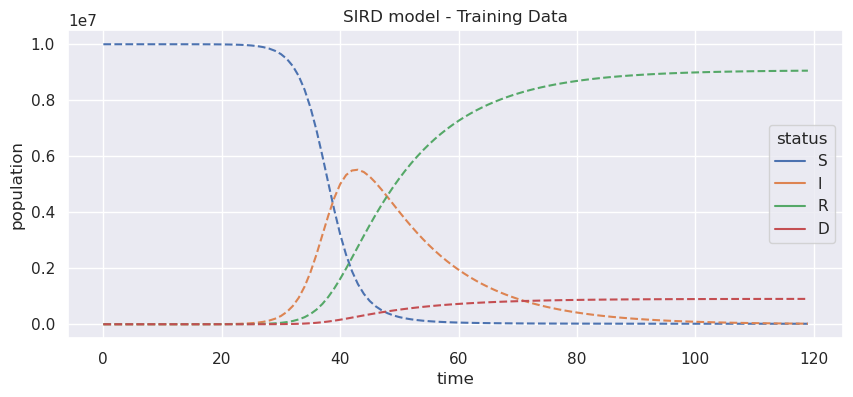

In [19]:
model_name = "SIRD"
populations_names = list(model_name)
data_real = (
        pd.DataFrame(y_train, columns=populations_names)
        .assign(time=t_train)
        .melt(id_vars="time", var_name="status", value_name="population")
)

fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(
    data=data_real,
    x="time",
    y="population",
    hue="status",
    legend=True,
    linestyle="dashed",
    ax=ax
)

ax.set_title(f"{model_name} model - Training Data")
fig.show()

## Disease Informed Neural Networks

### Varibles

Now let's start with parameter prediction. Define a initial guess for those parameters we want to estimate.

In [6]:
_beta = dde.Variable(0.0)
_omega = dde.Variable(0.0)
_gamma = dde.Variable(0.0)

### ODE Residuals

Residuals of this system are

$$
\begin{aligned}
\mathcal{L}_{\mathcal{F}_S} &= \frac{dS}{dt} - \left( - \frac{\beta S}{N} I \right) \\
\mathcal{L}_{\mathcal{F}_I} &= \frac{dI}{dt} - \left( \frac{\beta S}{N} I - \omega I - \gamma I \right) \\
\mathcal{L}_{\mathcal{F}_R} &= \frac{dR}{dt} - \omega I\\
\mathcal{L}_{\mathcal{F}_D} &= \frac{dD}{dt} - \gamma I
\end{aligned}
$$

In [7]:
def ode(t, y):

    S = y[:, 0:1]
    I = y[:, 1:2]
    R = y[:, 2:3]
    D = y[:, 3:4]

    dS_dt = dde.grad.jacobian(y, t, i=0)
    dI_dt = dde.grad.jacobian(y, t, i=1)
    dR_dt = dde.grad.jacobian(y, t, i=2)
    dD_dt = dde.grad.jacobian(y, t, i=3)

    return [
        dS_dt - ( - _beta * S / N * I ),
        dI_dt - ( _beta * S / N * I - _omega * I - _gamma * I  ),
        dR_dt - ( _omega * I ),
        dD_dt - ( _gamma * I )
    ]

### Initial Conditions

In [8]:
# Geometry
geom = dde.geometry.TimeDomain(t_train[0, 0], t_train[-1, 0])

# Boundaries
def boundary(_, on_initial):
    return on_initial

# Initial conditions
S_0, I_0, R_0, D_0 = y_train[0, :]
ic_S = dde.icbc.IC(geom, lambda x: S_0, boundary, component=0)
ic_I = dde.icbc.IC(geom, lambda x: I_0, boundary, component=1)
ic_R = dde.icbc.IC(geom, lambda x: R_0, boundary, component=2)
ic_D = dde.icbc.IC(geom, lambda x: D_0, boundary, component=3)

### Observed Data

In [9]:
observed_S = dde.icbc.PointSetBC(t_train, y_train[:, 0:1], component=0)
observed_I = dde.icbc.PointSetBC(t_train, y_train[:, 1:2], component=1)
observed_R = dde.icbc.PointSetBC(t_train, y_train[:, 2:3], component=2)
observed_D = dde.icbc.PointSetBC(t_train, y_train[:, 3:4], component=3)

### Data Model

In [10]:
data = dde.data.PDE(
    geom,
    ode,
    [
        ic_S,
        ic_I,
        ic_R,
        ic_D,
        observed_S,
        observed_I,
        observed_R,
        observed_D,
    ],
    num_domain=256,
    num_boundary=2,
    anchors=t_train,
)

### Neural Network

We need to define the structure of the network, once again, there is just one input (time) but there are four neurons in the last layer since we are working on a system of four equations.

![SIRD](../images/sird_dinn.png)

In [11]:
neurons = 64
layers = 3
activation = "relu"
net = dde.nn.FNN([1] + [neurons] * layers + [4], activation, "Glorot uniform")

### Training

In [12]:
variable_filename = "sird_variables.dat"
variable = dde.callbacks.VariableValue(
    [_beta, _omega, _gamma],
    period=100,
    filename=variable_filename
)

Compiling model...
Building feed-forward neural network...
'build' took 0.022074 s



/home/alonsolml/mambaforge/envs/nc-book/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:103: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
2023-03-15 16:43:46.015441: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-15 16:43:46.016381: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-15 16:43:46.016428: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open fil

'compile' took 1.370994 s

Initializing variables...
Training model...



2023-03-15 16:43:47.370654: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
2023-03-15 16:43:47.412209: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f2348009350 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-15 16:43:47.412232: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2023-03-15 16:43:47.449645: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: Permission denied
2023-03-15 16:43:47.484254: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2023-03-15 16:43:47.532437: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


Step      Train loss                                                                                                                  Test loss                                                                                                                   Test metric
0         [9.38e-04, 2.81e-02, 8.57e-04, 8.29e-05, 1.00e+14, 1.00e+00, 0.00e+00, 0.00e+00, 3.01e+13, 3.64e+12, 4.21e+13, 4.21e+11]    [9.38e-04, 2.81e-02, 8.57e-04, 8.29e-05, 1.00e+14, 1.00e+00, 0.00e+00, 0.00e+00, 3.01e+13, 3.64e+12, 4.21e+13, 4.21e+11]    []  


2023-03-15 16:43:48.270671: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


5000      [6.41e+07, 1.65e+06, 3.59e+07, 9.98e+05, 2.89e+13, 2.67e+11, 1.18e+13, 6.48e+10, 1.95e+13, 2.88e+12, 1.99e+13, 2.37e+11]    [6.41e+07, 1.65e+06, 3.59e+07, 9.98e+05, 2.89e+13, 2.67e+11, 1.18e+13, 6.48e+10, 1.95e+13, 2.88e+12, 1.99e+13, 2.37e+11]    []  
10000     [3.33e+09, 3.35e+09, 1.52e+09, 5.02e+07, 4.24e+06, 1.07e+10, 7.92e+09, 6.81e+07, 7.78e+11, 1.19e+12, 1.10e+12, 1.01e+10]    [3.33e+09, 3.35e+09, 1.52e+09, 5.02e+07, 4.24e+06, 1.07e+10, 7.92e+09, 6.81e+07, 7.78e+11, 1.19e+12, 1.10e+12, 1.01e+10]    []  
15000     [2.24e+09, 2.29e+09, 1.73e+09, 3.16e+07, 7.25e+07, 1.90e+08, 4.92e+08, 3.24e+05, 1.95e+10, 1.12e+10, 4.37e+10, 1.29e+08]    [2.24e+09, 2.29e+09, 1.73e+09, 3.16e+07, 7.25e+07, 1.90e+08, 4.92e+08, 3.24e+05, 1.95e+10, 1.12e+10, 4.37e+10, 1.29e+08]    []  
20000     [3.36e+08, 4.77e+08, 1.35e+08, 4.88e+06, 1.04e+06, 3.32e+06, 8.10e+06, 6.67e+04, 1.29e+08, 2.84e+08, 4.83e+08, 1.27e+07]    [3.36e+08, 4.77e+08, 1.35e+08, 4.88e+06, 1.04e+06, 3.32e+06, 8.10e+06, 6.67e+

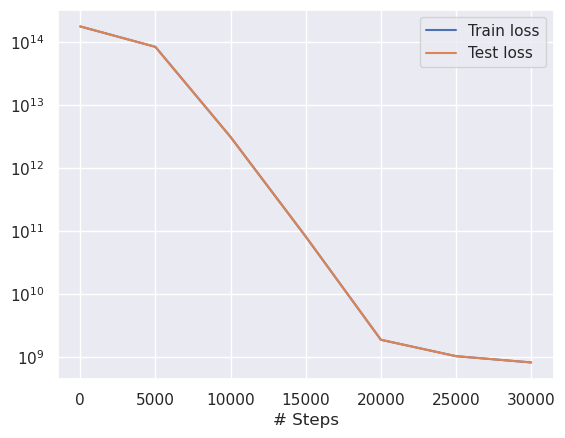

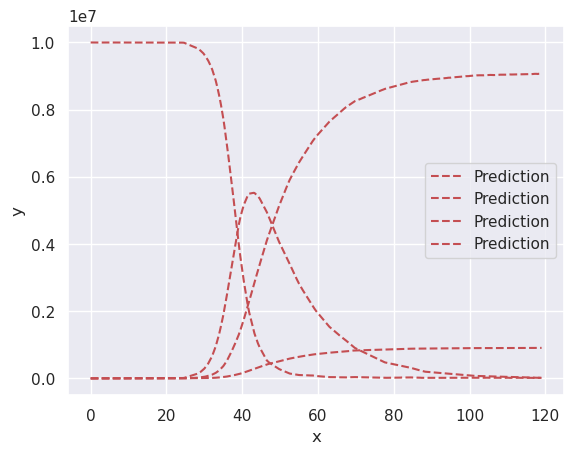

In [13]:
model = dde.Model(data, net)
model.compile(
    "adam",
    lr=1e-3,
    external_trainable_variables=[_beta, _omega, _gamma]
)
losshistory, train_state = model.train(
    iterations=30000,
    display_every=5000,
    callbacks=[variable]
)
dde.saveplot(losshistory, train_state, issave=False, isplot=True)

We can plot training and predicted data in the sample picture. You will notice it is almost perfect, which makes sense, since we are predicting data we already know.

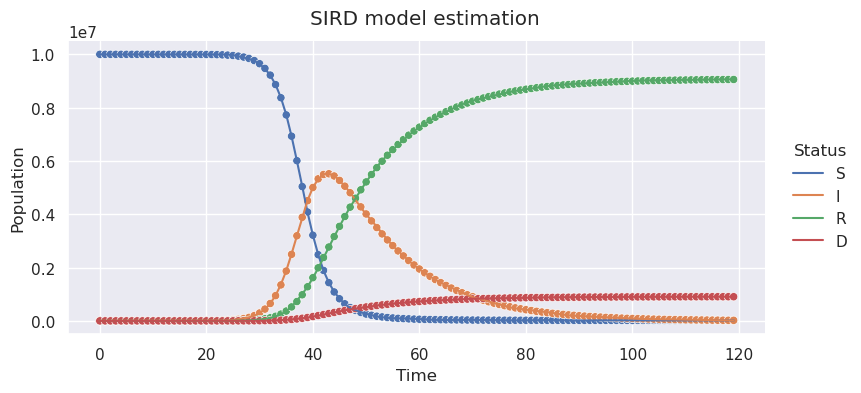

In [14]:
t_pred =  np.arange(0, n_days, 1)[:, np.newaxis]
y_pred = model.predict(t_pred)
data_pred = (
    pd.DataFrame(y_pred, columns=populations_names, index=t_pred.ravel())
    .rename_axis("time")
    .reset_index()
    .melt(id_vars="time", var_name="status", value_name="population")
)

g = sns.relplot(
    data=data_pred,
    x="time",
    y="population",
    hue="status",
    kind="line",
    aspect=2,
    height=4
)

sns.scatterplot(
    data=data_real,
    x="time",
    y="population",
    hue="status",
    ax=g.ax,
    legend=False
)

(
    g.set_axis_labels("Time", "Population")
    .tight_layout(w_pad=1)
)

g._legend.set_title("Status")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle(f"SIRD model estimation")

# plt.savefig("sird_prediction.png", dpi=300)
plt.show()

## Learning History

Let's study how well or bad this model learned the parameters of our infectious disease system.

In [15]:
lines = open(variable_filename, "r").readlines()
raw_parameters_pred_history = np.array(
    [
         np.fromstring(
            min(re.findall(re.escape("[") + "(.*?)" + re.escape("]"), line), key=len),
            sep=",",
        )
        for line in lines
    ]
)

iterations = [int(re.findall("^[0-9]+", line)[0]) for line in lines]

parameters_pred_history = {   
    name: raw_parameters_pred_history[:, i]
    for i, (name, nominal) in enumerate(parameters_real.items())
}

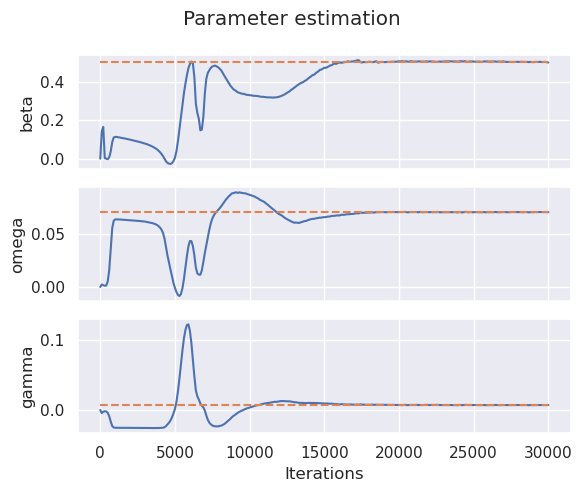

In [16]:
n_callbacis, n_variables = raw_parameters_pred_history.shape
fig, axes = plt.subplots(nrows=n_variables, sharex=True, figsize=(6, 5), layout="constrained")
for ax, (parameter, parameter_value) in zip(axes, parameters_real.items()):
    ax.plot(iterations, parameters_pred_history[parameter] , "-")
    ax.plot(iterations, np.ones_like(iterations) * parameter_value, "--")
    ax.set_ylabel(parameter)
ax.set_xlabel("Iterations")
fig.suptitle("Parameter estimation")
fig.tight_layout()
# fig.savefig("sird_parameter_estimation.png", dpi=300)

In [17]:
parameters_pred = {
    name: var for name, var in zip(parameters_real.keys(), variable.value)
}
error_df = (
    pd.DataFrame(
        {
            "Real": parameters_real,
            "Predicted": parameters_pred
        }
    )
    .assign(
        **{"Relative Error": lambda x: (x["Real"] - x["Predicted"]).abs() / x["Real"]}
    )
)
error_df

,Real,Predicted,Relative Error
beta,0.500000,0.499499,0.001002
omega,0.071429,0.071153,0.003864
gamma,0.007143,0.007032,0.015463


With a few of iterations (neural networks in industry can take millions and billions of iterations) we were able to obtain results with around a 0.01 relative error. This predictions can be better hyper-tuning algorithm's parameters, however, that is out of the scope of this course.